# Profiling and Analysis Questions

- Do users purchase different products at different time of day?
- What clusters of aisle purchase standout?
- Do users who reorder have different behaviour? 
- does the behaviour change per number of order (eg.: min vs median, etc)
- do users purchase differently depending on days or weeks since last purchase?
- do users purchase differently on the weekends vs weekday?
- What is the top product/aisle purchased first or last per order?
- Reordered is per product. what products are most reordered by users?
- how many orders per user_id? 

## Aggregations
- days/weeks since last order
- number of orders (better to consider order number instead of count of order_id due to incomplete customer history)
- number of users who reordered
- orders per time of day (numeric or discrete count)


# File and libraries

In [10]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart User Aggregated Behaviour"


## DSLabs

In [11]:
%run "scripts/dslabs_functions.py"

# data functions

In [12]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [13]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    # sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample.csv')
    # users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group 1%   
    # sample=0.1


    # data=pd.read_csv(filepath)

    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    # users_df=users_df.sample(frac=sample)





data=users_df.copy()

id_cols=['user_id']


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41242 entries, 0 to 41241
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  41242 non-null  int64  
 1   total_orders             41242 non-null  int64  
 2   total_products           41242 non-null  int64  
 3   mean_lag_between_orders  41242 non-null  float64
 4   std_lag_between_orders   41242 non-null  float64
 5   mean_reorder_rate        41242 non-null  float64
 6   mean_weekend_order       41242 non-null  float64
 7   mean_order_dow           41242 non-null  float64
 8   mean_order_hour          41242 non-null  float64
 9   median_order_hour        41242 non-null  float64
 10  peak_order_hour          41242 non-null  int64  
 11  order_day_variety        41242 non-null  int64  
 12  order_frequency          41242 non-null  float64
 13  reorder_ratio            41242 non-null  float64
 14  unique_products       

# Dimensionality

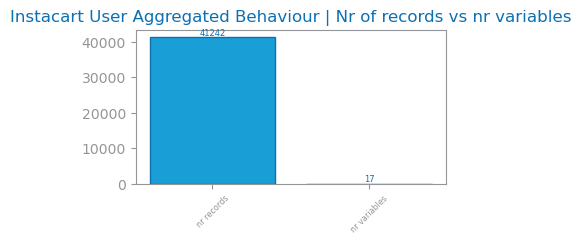

In [14]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title=f"{file_tag} | Nr of records vs nr variables"
)
# savefig(f"{file_tag}_records_variables.png")
show()

## Missing values
- Only missing values for dataset are the columns "days since last order" at 6.5%. When the order is the user's first, this column shows empty values. It cannot be filled with '0' since there are users that can make multiple orders in the same day. Would not remove it as well as it can be used for analysis questions like 'behaviour on first order'?

In [15]:
data.isnull().sum()


user_id                    0
total_orders               0
total_products             0
mean_lag_between_orders    0
std_lag_between_orders     0
mean_reorder_rate          0
mean_weekend_order         0
mean_order_dow             0
mean_order_hour            0
median_order_hour          0
peak_order_hour            0
order_day_variety          0
order_frequency            0
reorder_ratio              0
unique_products            0
weekend_order_ratio        0
order_size_variability     0
dtype: int64

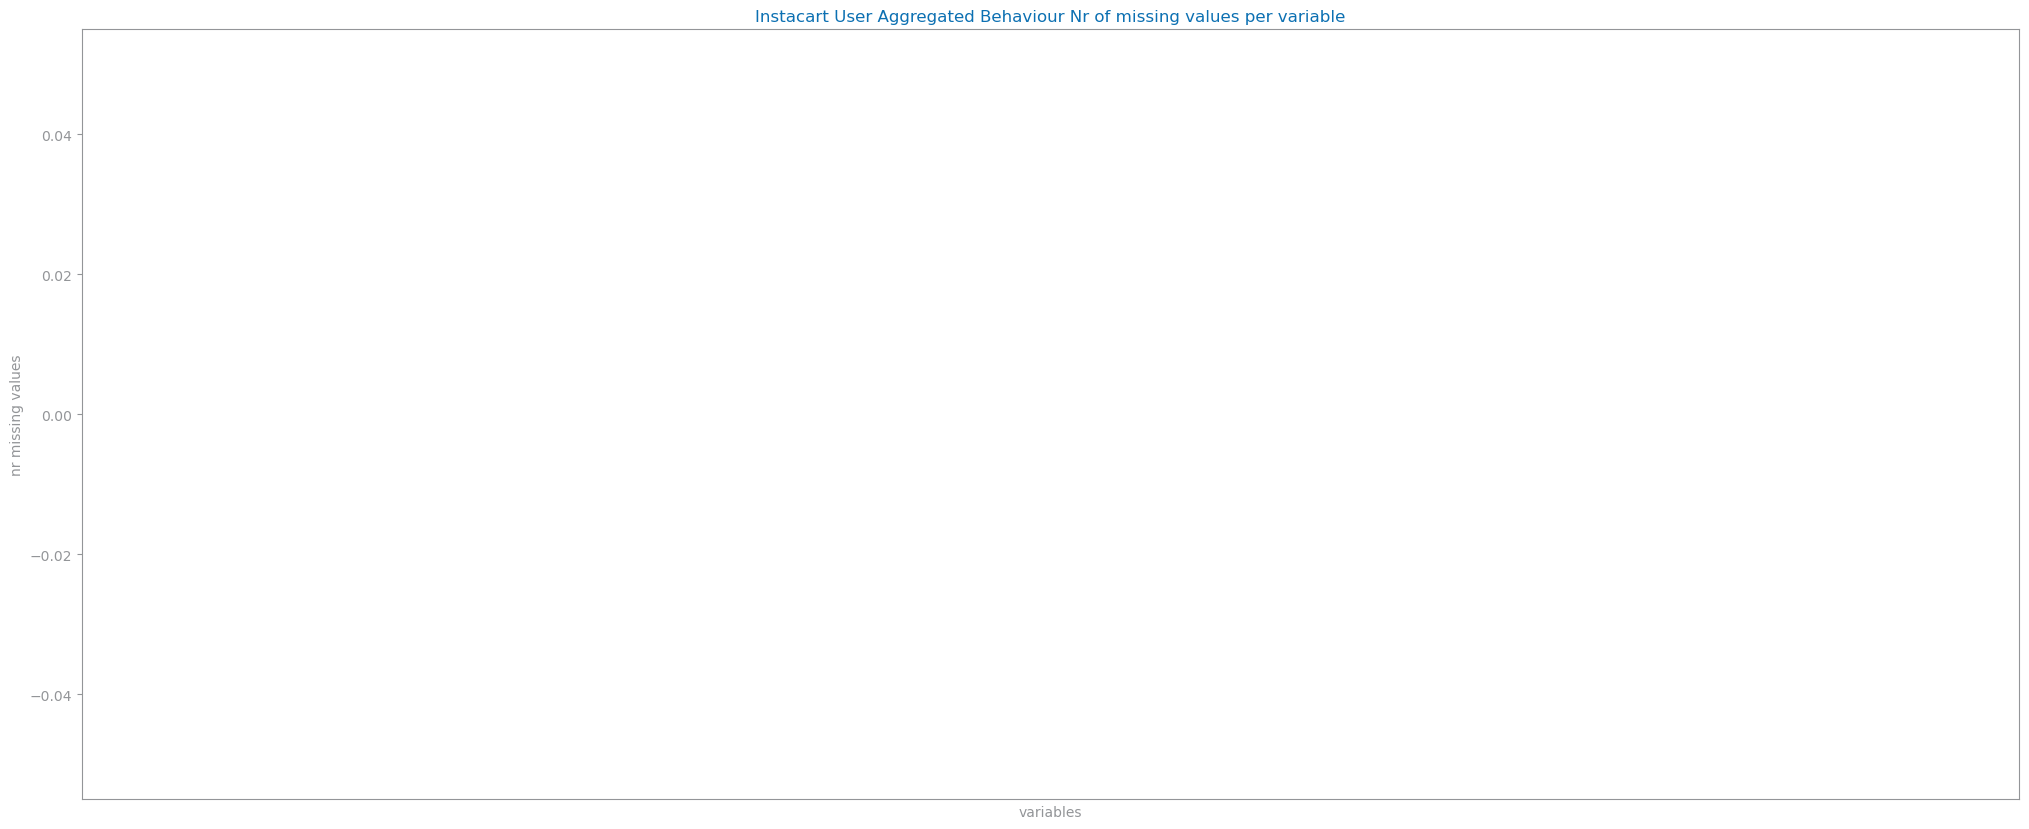

In [16]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
total_rows = len(data)

for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

figure(figsize=(25, 10)) #(largura,altura) 

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

savefig(f"images/{file_tag}_mv.png")
show()

## Variables Type

In [17]:
data.dtypes


user_id                      int64
total_orders                 int64
total_products               int64
mean_lag_between_orders    float64
std_lag_between_orders     float64
mean_reorder_rate          float64
mean_weekend_order         float64
mean_order_dow             float64
mean_order_hour            float64
median_order_hour          float64
peak_order_hour              int64
order_day_variety            int64
order_frequency            float64
reorder_ratio              float64
unique_products              int64
weekend_order_ratio        float64
order_size_variability     float64
dtype: object

In [18]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['total_orders', 'total_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order', 'mean_order_dow', 'mean_order_hour', 'median_order_hour', 'peak_order_hour', 'order_day_variety', 'order_frequency', 'reorder_ratio', 'unique_products', 'weekend_order_ratio', 'order_size_variability'], 'binary': [], 'date': [], 'symbolic': [], 'id': ['user_id']}


### variables per type plot

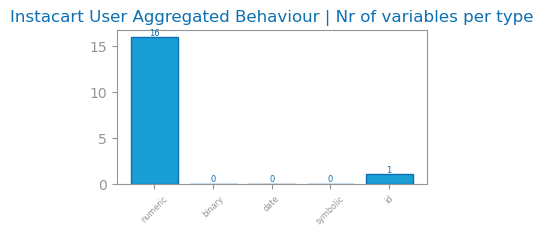

In [19]:
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title=f"{file_tag} | Nr of variables per type"
)
# savefig(f"{file_tag}_variable_types.png")
show()

# Data Distribution

## describe

In [20]:
summary5: DataFrame = data.describe(include="all")
summary5

,user_id,total_orders,total_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,mean_order_hour,median_order_hour,peak_order_hour,order_day_variety,order_frequency,reorder_ratio,unique_products,weekend_order_ratio,order_size_variability
count,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,4.124200e+04,41242.000000,41242.000000,41242.000000,41242.000000
mean,103000.774041,15.593958,2461.780491,15.460017,6.614981,0.432805,0.265485,2.749285,13.546458,13.535789,13.265239,4.698681,inf,0.001922,15.593958,0.035731,3.967196
std,59573.771037,16.725599,4688.812210,7.188655,3.262821,0.211340,0.215545,1.008183,2.204708,2.833755,3.978134,1.681442,NaN,0.008955,16.725599,0.051923,2.539258
min,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e-01,0.000000,3.000000,0.000000,0.000000
25%,51250.000000,5.000000,316.000000,9.557153,4.223882,0.270833,0.098765,2.117647,12.117647,12.000000,10.000000,3.000000,2.881491e-01,0.000150,5.000000,0.004171,2.130822
50%,103314.500000,9.000000,965.000000,14.727273,7.042454,0.429691,0.238095,2.755300,13.515970,13.500000,13.000000,5.000000,6.443872e-01,0.000329,9.000000,0.015779,3.508089
75%,154673.500000,19.000000,2627.750000,20.644444,9.022754,0.593901,0.388060,3.364696,14.967742,15.000000,16.000000,6.000000,1.683975e+00,0.000891,19.000000,0.044025,5.254286
max,206206.000000,99.000000,156235.000000,30.000000,21.213203,0.979310,1.000000,6.000000,22.716667,23.000000,23.000000,7.000000,inf,0.222222,99.000000,0.333333,33.688547


## Numeric Variables

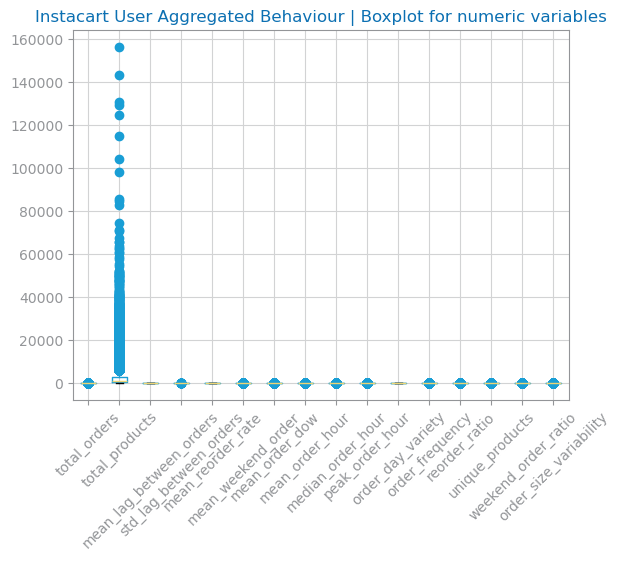

In [21]:
from matplotlib.pyplot import savefig, show, title


variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    data[numeric].boxplot(rot=45)
    title(f'{file_tag} | Boxplot for numeric variables')  # Correct way to set title
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

## numeric variables distribution breakdown
- add_to_cart_order, order number and weeks since last order should be truncated or removed

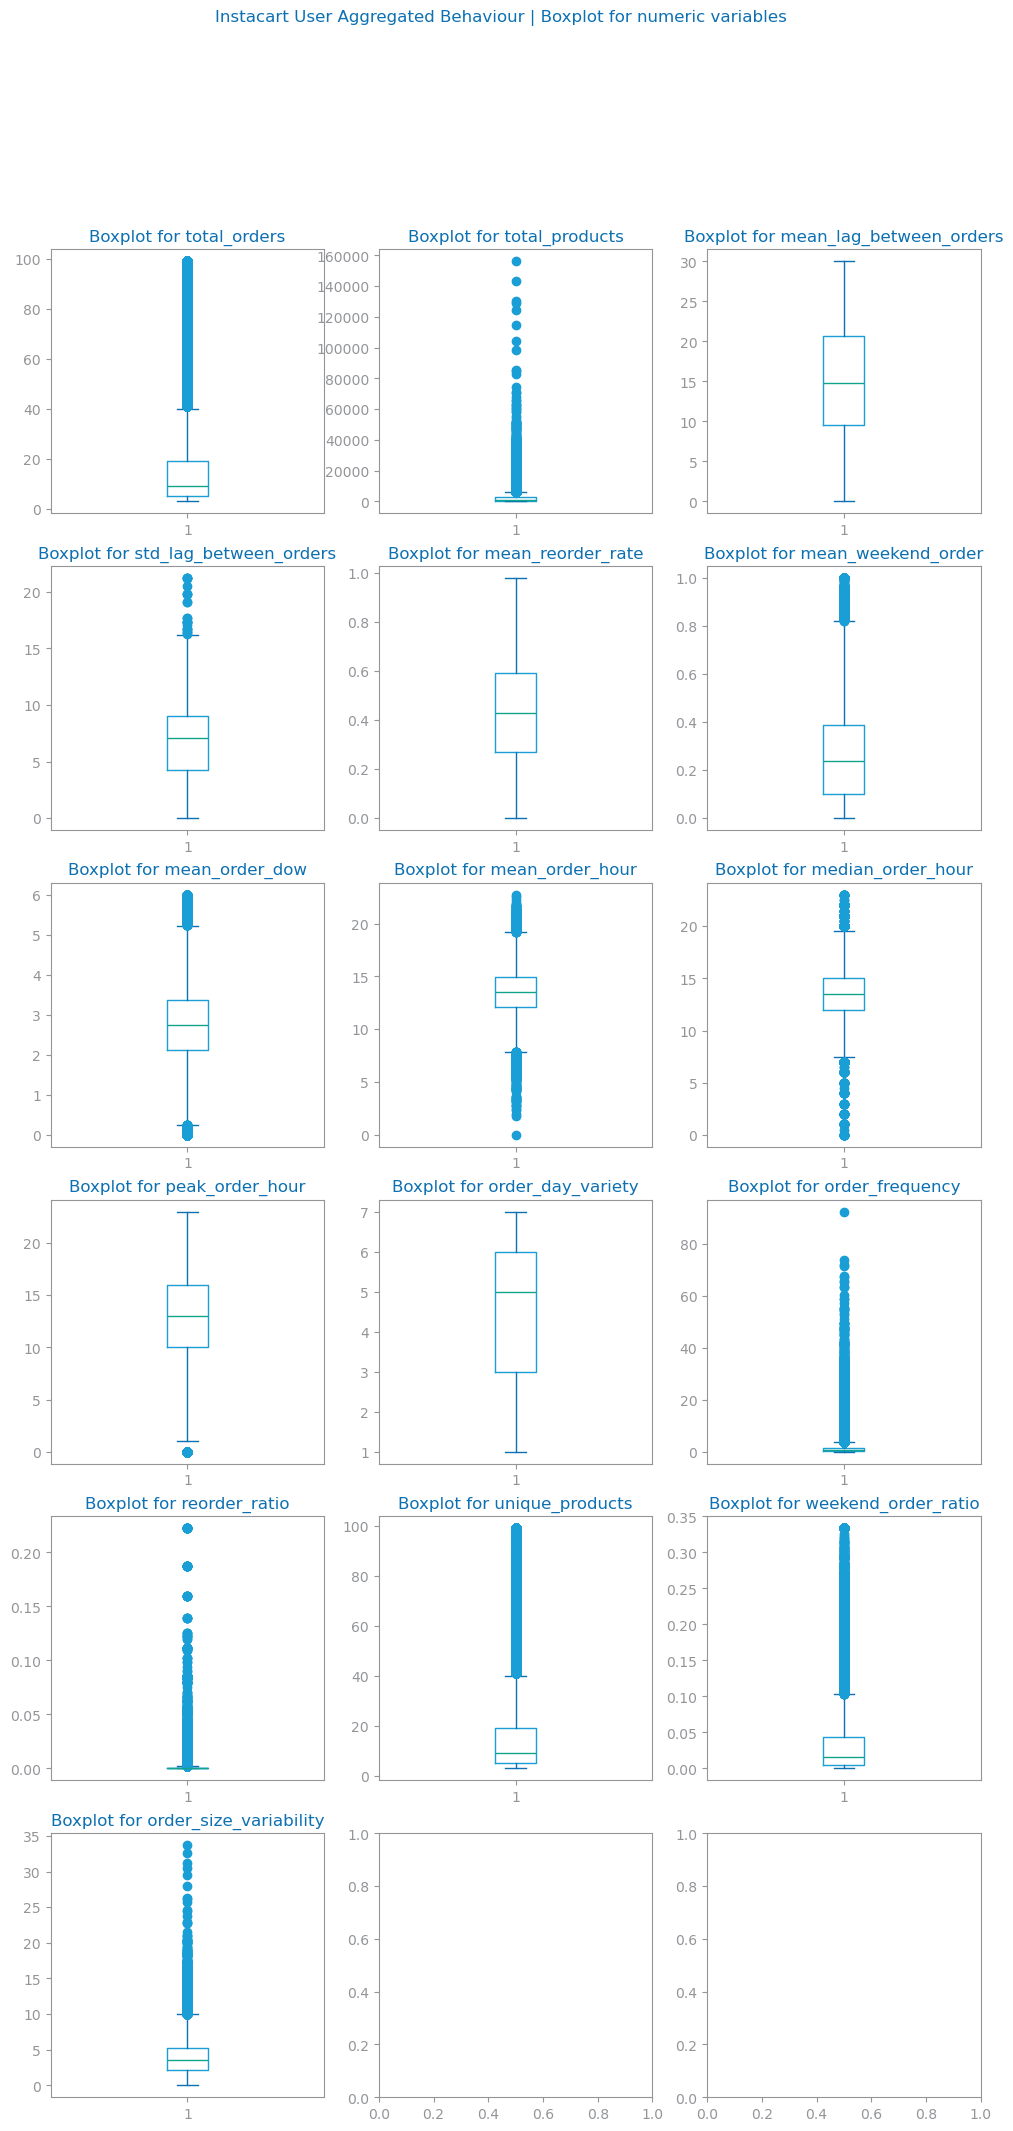

In [22]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## standard outliers for numeric variables

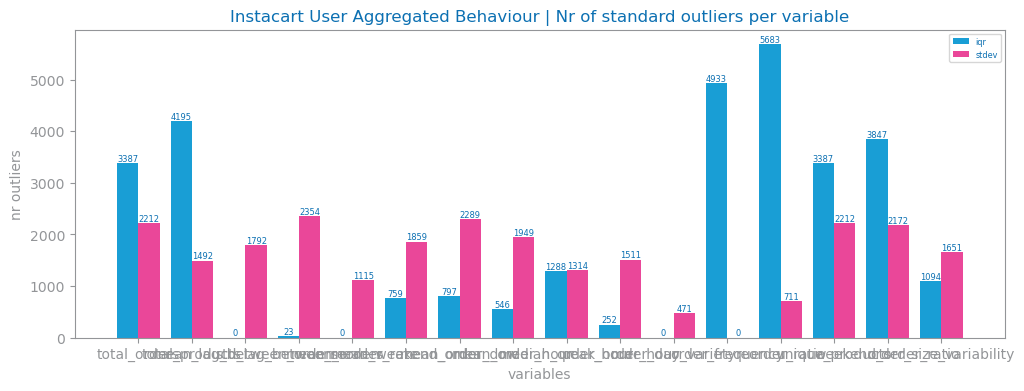

In [23]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

## outliers factorized

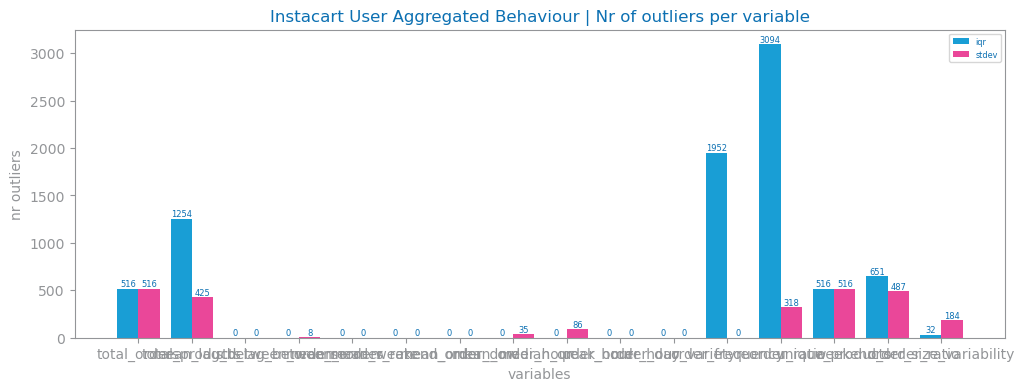

In [24]:
if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=4, iqrfactor=4.5)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers.png")
    show()
else:
    print("There are no numeric variables.")

## numeric histograms

ValueError: supplied range of [0.1, inf] is not finite

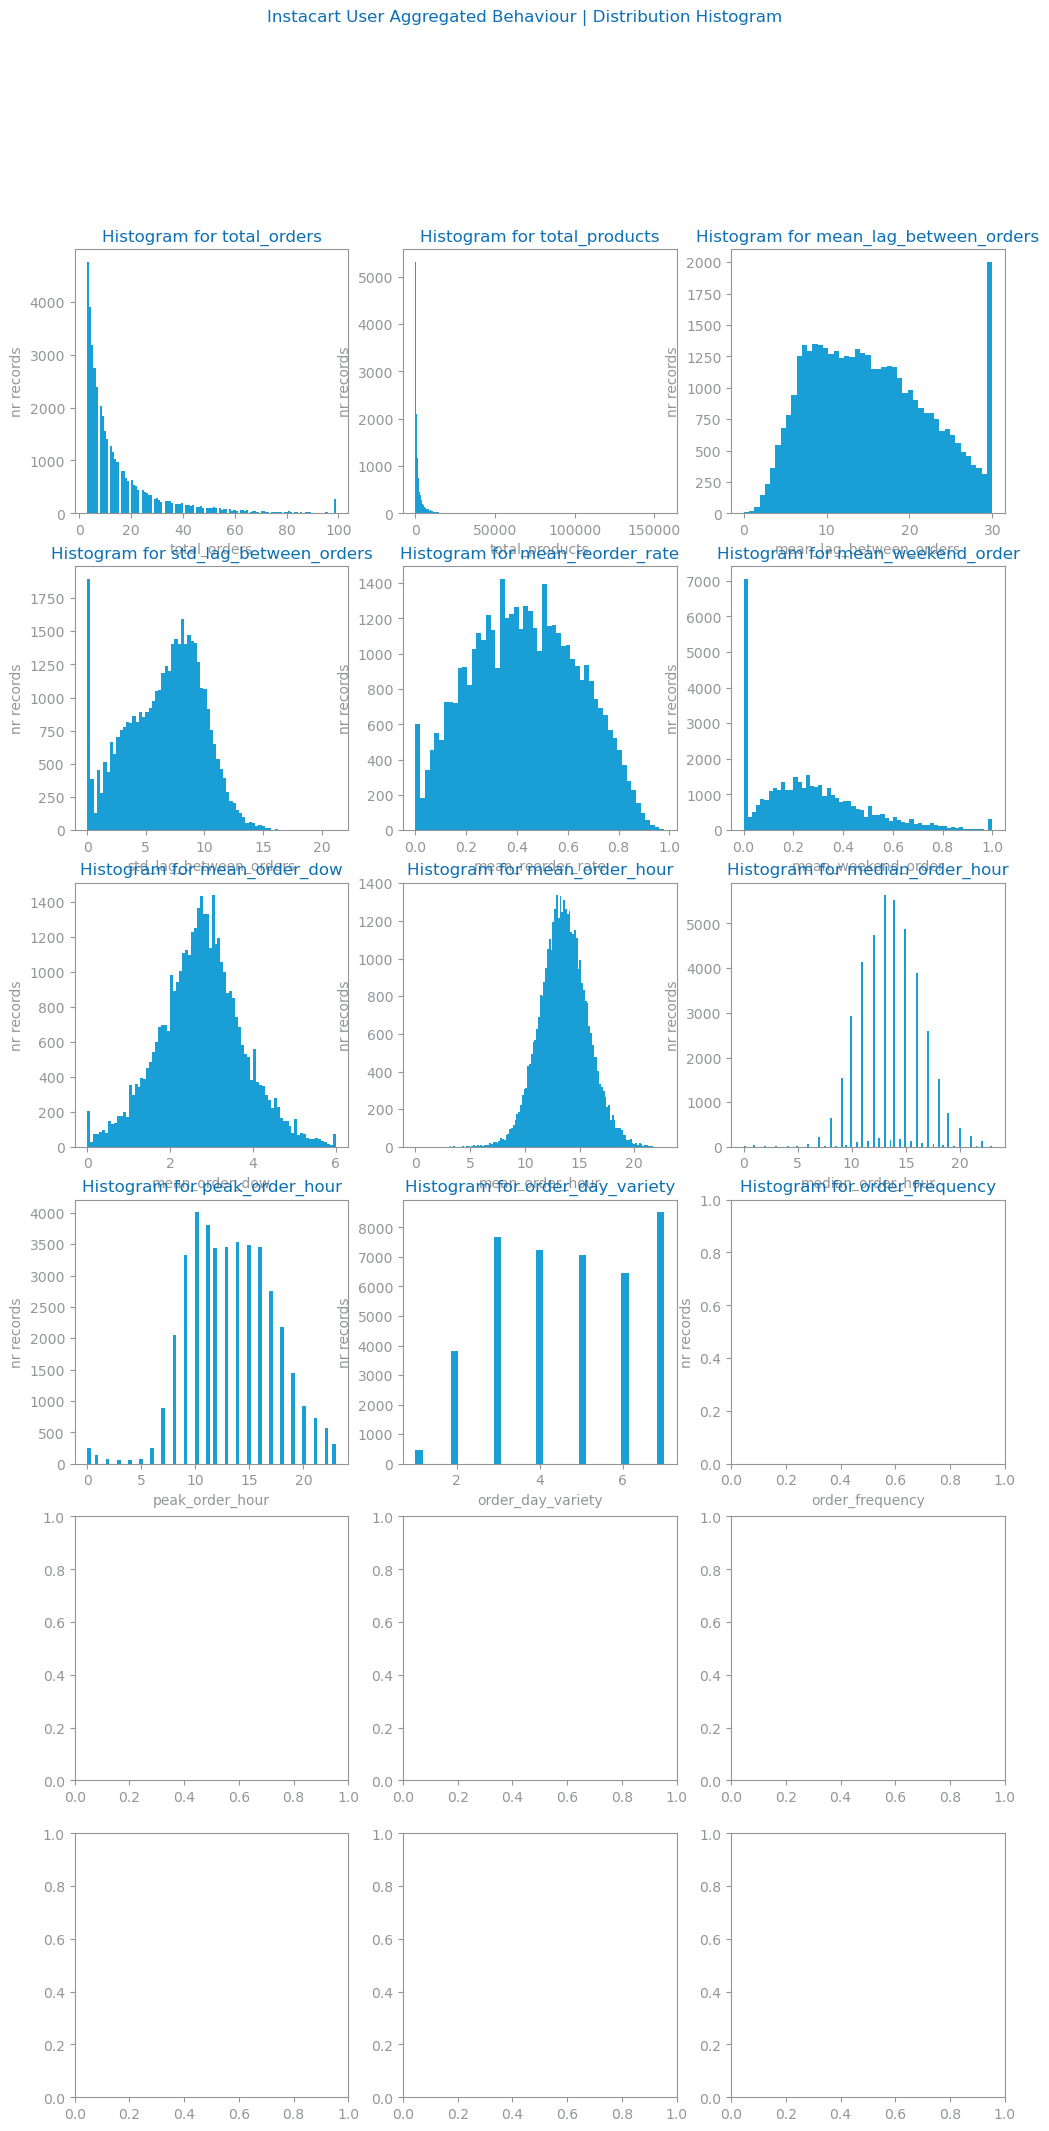

In [25]:
from dslabs_functions import set_chart_labels


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    
    fig.suptitle(f'{file_tag} | Distribution Histogram')

    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

# Correlation Analysis

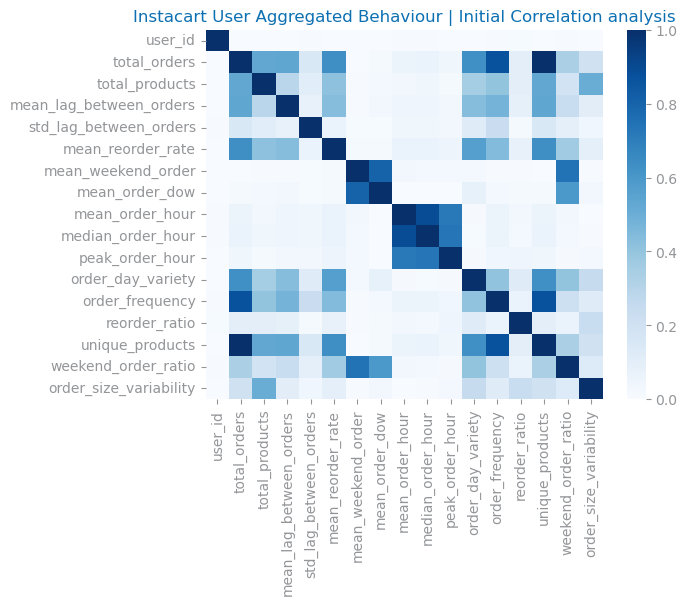

In [26]:
from seaborn import heatmap
from dslabs_functions import get_variable_types
from matplotlib.pyplot import figure, title, savefig, show

variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = data[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)

title(f'{file_tag} | Initial Correlation analysis')

savefig(f"images/{file_tag}_correlation_analysis.png")
show()